In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('tiktok_dataset.csv')

In [3]:
data.head(10)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
5,6,claim,8972200955,35,someone shared with me that gross domestic pro...,not verified,under review,336647.0,175546.0,62303.0,4293.0,1857.0
6,7,claim,4958886992,16,someone shared with me that elvis presley has ...,not verified,active,750345.0,486192.0,193911.0,8616.0,5446.0
7,8,claim,2270982263,41,someone shared with me that the best selling s...,not verified,active,547532.0,1072.0,50.0,22.0,11.0
8,9,claim,5235769692,50,someone shared with me that about half of the ...,not verified,active,24819.0,10160.0,1050.0,53.0,27.0
9,10,claim,4660861094,45,someone shared with me that it would take a 50...,verified,active,931587.0,171051.0,67739.0,4104.0,2540.0


In [4]:
df = data.copy()

In [5]:
# numeric → fill NaN with 0
num_cols = [
    "video_duration_sec",
    "video_view_count",
    "video_like_count",
    "video_share_count",
    "video_download_count",
    "video_comment_count",
]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

In [6]:
# categorical → lowercase/strip, fill NaN with "unknown"
category_cols = ["claim_status", "verified_status", "author_ban_status"]
for c in category_cols:
    df[c] = df[c].astype(str).str.lower().str.strip().replace({"nan": np.nan}).fillna("unknown")

# text → fill NaN with empty string
if "video_transcription_text" in df.columns:
    df["video_transcription_text"] = df["video_transcription_text"].fillna("").astype(str)

In [7]:
# drop exact dupes by video_id if present
if "video_id" in df.columns:
    df = df.drop_duplicates(subset="video_id", keep="first")

In [8]:
print("Cleaned shape:", df.shape)
df.head(5)

Cleaned shape: (19382, 12)


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [9]:
# Check for zero values in key numeric columns
num_cols = [
    "video_view_count",
    "video_like_count",
    "video_share_count",
    "video_download_count",
    "video_comment_count"
]

(df[num_cols] == 0).sum()

video_view_count         298
video_like_count         302
video_share_count        397
video_download_count    1275
video_comment_count     3732
dtype: int64

In [10]:
# Engagement ratios
df["engagement_rate"] = ((df["video_like_count"] + df["video_share_count"] + df["video_comment_count"] + df["video_download_count"])/ df["video_view_count"])

df["like_ratio"] = df["video_like_count"] / df["video_view_count"]
df["share_ratio"] = df["video_share_count"] / df["video_view_count"]
df["comment_ratio"] = df["video_comment_count"] / df["video_view_count"]

# Replace inf/nan with 0 (from division by 0 views)
df[["engagement_rate","like_ratio","share_ratio","comment_ratio"]] = (df[["engagement_rate","like_ratio","share_ratio","comment_ratio"]]
    .replace([np.inf, -np.inf], 0).fillna(0))

# Handle div/0 → replace inf/nan with 0
ratio_cols = ["engagement_rate","like_ratio","share_ratio","comment_ratio"]
df[ratio_cols] = df[ratio_cols].replace([np.inf, -np.inf], 0).fillna(0)

df[ratio_cols].describe()

,engagement_rate,like_ratio,share_ratio,comment_ratio
count,19382.000000,19382.000000,19382.000000,19382.000000
mean,0.330185,0.271848,0.054016,0.000940
std,0.215535,0.175000,0.050658,0.001321
min,0.000000,0.000000,0.000000,0.000000
25%,0.150308,0.124517,0.013514,0.000077
50%,0.312783,0.259708,0.038864,0.000440
75%,0.477160,0.396364,0.081017,0.001245
max,0.935961,0.666648,0.265956,0.010280


In [11]:
df.head(5) #after adding the ratios

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,engagement_rate,like_ratio,share_ratio,comment_ratio
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.057289,0.056584,0.000702,0.000000
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.697303,0.549096,0.135111,0.004855
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.112737,0.108282,0.003168,0.000365
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.632183,0.548459,0.079569,0.001335
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.708530,0.622910,0.073175,0.002706


In [12]:
# Video length buckets
"""
raw video_duration_sec is numeric, but length often has a non-linear effect:
Very short videos (<20s): often optimized for virality.
Medium (20–40s): typical TikTok range.
Long (>40s): less common, might affect engagement differently.

By bucketing, there is another categorical feature that models can use directly.
It helps simplify patterns instead of treating every second as unique.
"""
def bucket_length(x):
    if x < 20:
        return "short"
    elif x <= 40:
        return "medium"
    else:
        return "long"

df["video_length_bucket"] = df["video_duration_sec"].apply(bucket_length)

df["video_length_bucket"].value_counts()

video_length_bucket
medium    7211
long      6932
short     5239
Name: count, dtype: int64

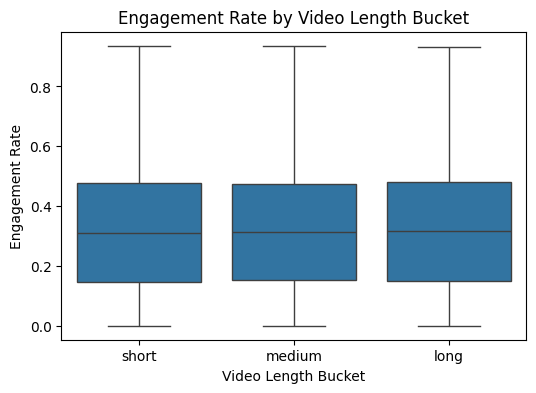

In [13]:
# Boxplot of engagement by video length bucket
plt.figure(figsize=(6,4))
sns.boxplot(x="video_length_bucket", y="engagement_rate", data=df, order=["short","medium","long"])
plt.title("Engagement Rate by Video Length Bucket")
plt.xlabel("Video Length Bucket")
plt.ylabel("Engagement Rate")
plt.show()

In [14]:
# Boolean encodings

df["is_claim"] = (df["claim_status"] == "claim").astype(int)
df["is_verified"] = (df["verified_status"] == "verified").astype(int)
df["is_author_banned"] = (df["author_ban_status"] == "banned").astype(int)

df[["claim_status","is_claim","verified_status","is_verified","author_ban_status","is_author_banned"]].head(10)

,claim_status,is_claim,verified_status,is_verified,author_ban_status,is_author_banned
0,claim,1,not verified,0,under review,0
1,claim,1,not verified,0,active,0
2,claim,1,not verified,0,active,0
3,claim,1,not verified,0,active,0
4,claim,1,not verified,0,active,0
5,claim,1,not verified,0,under review,0
6,claim,1,not verified,0,active,0
7,claim,1,not verified,0,active,0
8,claim,1,not verified,0,active,0
9,claim,1,verified,1,active,0


In [15]:
# Phase 1 summary (engineered columns only)
engineered_cols = ["engagement_rate", "like_ratio", "share_ratio", "comment_ratio","video_length_bucket",
    "is_claim", "is_verified", "is_author_banned"]

print("Phase 1 complete. Engineered columns created:\n", engineered_cols)

df.head(3)

Phase 1 complete. Engineered columns created:
 ['engagement_rate', 'like_ratio', 'share_ratio', 'comment_ratio', 'video_length_bucket', 'is_claim', 'is_verified', 'is_author_banned']


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,engagement_rate,like_ratio,share_ratio,comment_ratio,video_length_bucket,is_claim,is_verified,is_author_banned
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.057289,0.056584,0.000702,0.000000,long,1,0,0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.697303,0.549096,0.135111,0.004855,medium,1,0,0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.112737,0.108282,0.003168,0.000365,medium,1,0,0


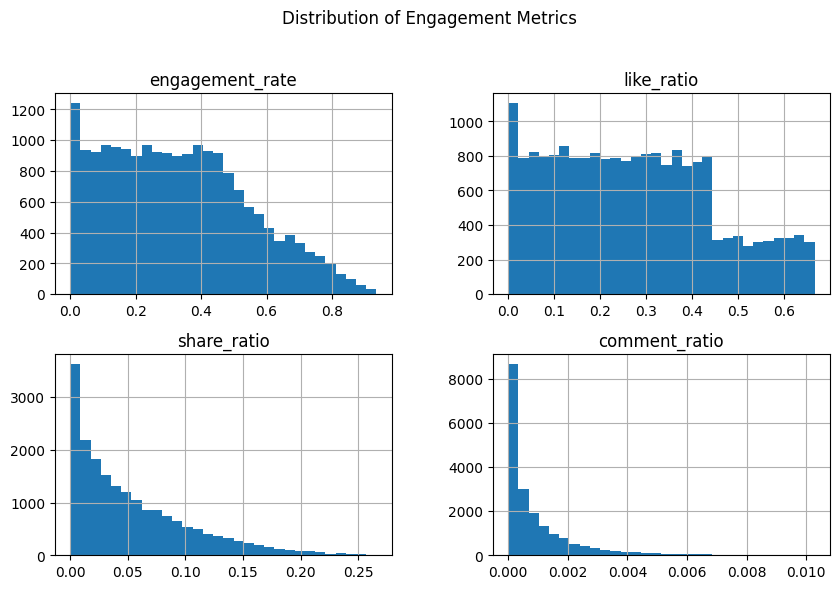

In [16]:
# Phase 2  
# Histograms of engagement metrics
engagement_cols = ["engagement_rate", "like_ratio", "share_ratio", "comment_ratio"]

df[engagement_cols].hist(bins=30, figsize=(10,6))
plt.suptitle("Distribution of Engagement Metrics", y=1.02)
plt.show()

In [17]:
"""
engagement_rate: fairly spread between 0–0.9, mean around 0.33.
like_ratio: main driver, spread fairly evenly up to ~0.6.
share_ratio: very right-skewed — most videos have tiny share rates, a few outliers get big shares.
comment_ratio: extremely right-skewed — almost all videos have very low comment ratios.
"""

'\nengagement_rate: fairly spread between 0–0.9, mean around 0.33.\nlike_ratio: main driver, spread fairly evenly up to ~0.6.\nshare_ratio: very right-skewed — most videos have tiny share rates, a few outliers get big shares.\ncomment_ratio: extremely right-skewed — almost all videos have very low comment ratios.\n'

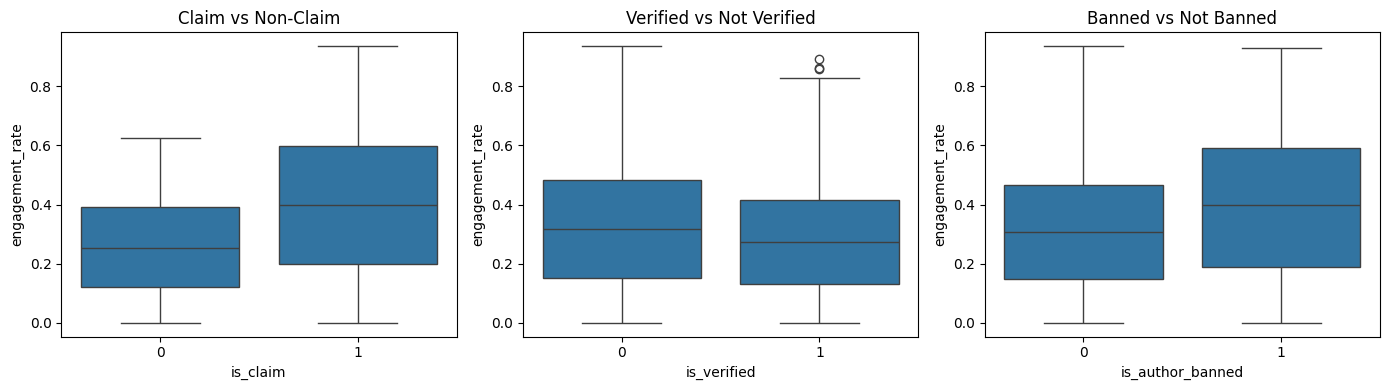

In [18]:
# Boxplots: engagement_rate by claim / verified / banned

fig, axes = plt.subplots(1, 3, figsize=(14,4))

sns.boxplot(x="is_claim", y="engagement_rate", data=df, ax=axes[0])
axes[0].set_title("Claim vs Non-Claim")

sns.boxplot(x="is_verified", y="engagement_rate", data=df, ax=axes[1])
axes[1].set_title("Verified vs Not Verified")

sns.boxplot(x="is_author_banned", y="engagement_rate", data=df, ax=axes[2])
axes[2].set_title("Banned vs Not Banned")

plt.tight_layout()
plt.show()

In [19]:
"""
Claims: visibly higher median engagement compared to non-claims.
Verified: engagement looks slightly lower than non-verified (opposite of what you might expect).
Banned Authors: higher median engagement than non-banned.
Claims and controversial/banned content may attract higher engagement, verified status doesn’t guarantee it.
"""

'\nClaims: visibly higher median engagement compared to non-claims.\nVerified: engagement looks slightly lower than non-verified (opposite of what you might expect).\nBanned Authors: higher median engagement than non-banned.\nClaims and controversial/banned content may attract higher engagement, verified status doesn’t guarantee it.\n'

In [20]:
# Grouped summary (mean & median engagement)

summary = pd.DataFrame({
    "is_claim_mean": df.groupby("is_claim")["engagement_rate"].mean(),
    "is_claim_median": df.groupby("is_claim")["engagement_rate"].median(),
    "is_verified_mean": df.groupby("is_verified")["engagement_rate"].mean(),
    "is_verified_median": df.groupby("is_verified")["engagement_rate"].median(),
    "is_author_banned_mean": df.groupby("is_author_banned")["engagement_rate"].mean(),
    "is_author_banned_median": df.groupby("is_author_banned")["engagement_rate"].median(),
}).T

summary

,0,1
is_claim_mean,0.258598,0.403009
is_claim_median,0.253274,0.396782
is_verified_mean,0.333439,0.282577
is_verified_median,0.316015,0.273611
is_author_banned_mean,0.323971,0.397449
is_author_banned_median,0.307420,0.398040


In [21]:
"""
is_claim_mean: ~0.40 vs 0.25 → claims boost engagement.
is_verified_mean: 0.28 vs 0.33 → verified slightly underperforms.
is_author_banned_mean: 0.39 vs 0.32 → banned authors’ videos attract more engagement.
"""

'\nis_claim_mean: ~0.40 vs 0.25 → claims boost engagement.\nis_verified_mean: 0.28 vs 0.33 → verified slightly underperforms.\nis_author_banned_mean: 0.39 vs 0.32 → banned authors’ videos attract more engagement.\n'

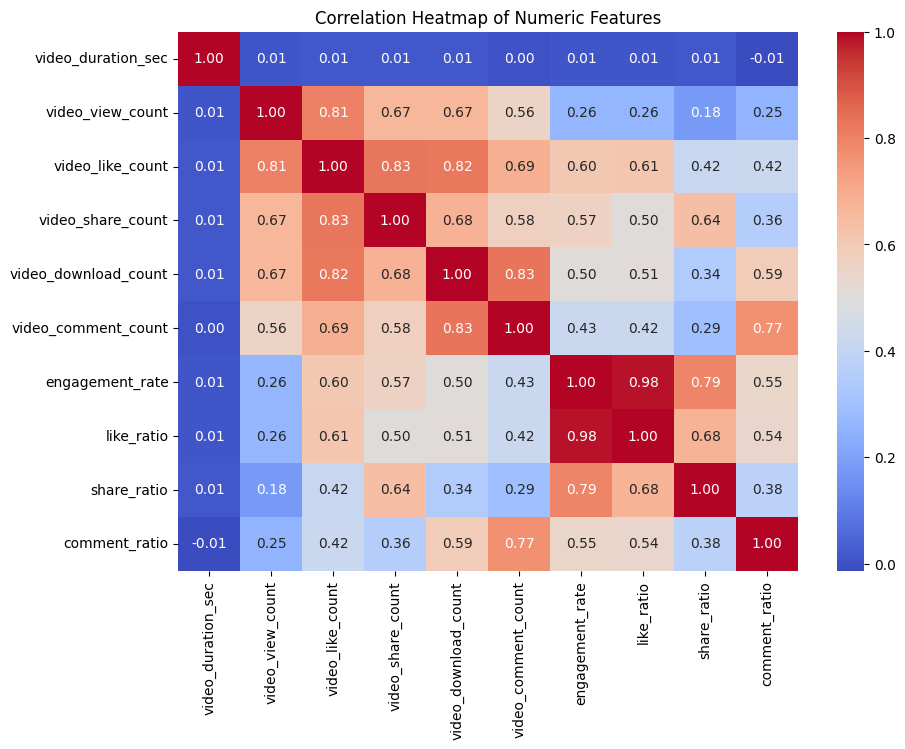

In [22]:
# Correlation heatmap (numeric features)

numeric_cols = [
    "video_duration_sec",
    "video_view_count",
    "video_like_count",
    "video_share_count",
    "video_download_count",
    "video_comment_count",
    "engagement_rate", "like_ratio", "share_ratio", "comment_ratio"
]

plt.figure(figsize=(10,7))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [23]:
"""
Strong correlations between views, likes, shares, downloads, comments (as expected — big videos get more of everything).
engagement_rate ≈ like_ratio (0.98).
Shares and comments are moderately correlated with engagement.
video_duration_sec has almost no correlation with anything.
Interpretation: video length has little predictive value.
"""

'\nStrong correlations between views, likes, shares, downloads, comments (as expected — big videos get more of everything).\nengagement_rate ≈ like_ratio (0.98).\nShares and comments are moderately correlated with engagement.\nvideo_duration_sec has almost no correlation with anything.\nInterpretation: video length has little predictive value.\n'

In [24]:
# Top correlations with engagement_rate

target_corr = (df[numeric_cols].corr()["engagement_rate"].drop("engagement_rate").sort_values(ascending=False))

print("Correlations with engagement_rate:\n")
print(target_corr)

Correlations with engagement_rate:

like_ratio              0.984860
share_ratio             0.794933
video_like_count        0.604124
video_share_count       0.567732
comment_ratio           0.546022
video_download_count    0.503973
video_comment_count     0.425393
video_view_count        0.260231
video_duration_sec      0.010066
Name: engagement_rate, dtype: float64


In [26]:
"""
like_ratio almost fully explains engagement_rate (since it’s a big component).
share_ratio adds extra predictive power.
raw counts (likes, shares, downloads) are moderately useful.
views (0.26) and duration (0.01) aren’t useful predictors.
Interpretation: when modeling engagement, focus on ratios, not raw counts or duration
"""

'\nlike_ratio almost fully explains engagement_rate (since it’s a big component).\nshare_ratio adds extra predictive power.\nraw counts (likes, shares, downloads) are moderately useful.\nviews (0.26) and duration (0.01) aren’t useful predictors.\nInterpretation: when modeling engagement, focus on ratios, not raw counts or duration\n'

In [27]:
#Avg likes, shares, comments by claim_status

cols = ["video_like_count", "video_share_count", "video_comment_count", "engagement_rate"]

claim_opinion_summary = (df.groupby("claim_status")[cols].mean().round(3))

print("Average engagement metrics by claim_status:")
display(claim_opinion_summary)

Average engagement metrics by claim_status:


,video_like_count,video_share_count,video_comment_count,engagement_rate
claim_status,,,,
claim,166373.331,33026.416,691.165,0.403
opinion,1092.730,217.146,2.697,0.267
unknown,0.000,0.000,0.000,0.000


In [31]:
"""
claim videos: very high avg likes (~166k), shares (~33k), comments (~691), engagement_rate ~0.40.
opinion videos: much lower likes (~1k), shares (~217), comments (~2.7), engagement_rate ~0.27.
unknown: basically empty / 0.

Interpretation: Claim videos are far more viral in terms of raw reach (likes, shares, comments). 
They also maintain a higher engagement rate than opinion content.
"""

'\nclaim videos: very high avg likes (~166k), shares (~33k), comments (~691), engagement_rate ~0.40.\nopinion videos: much lower likes (~1k), shares (~217), comments (~2.7), engagement_rate ~0.27.\nunknown: basically empty / 0.\n\nInterpretation: Claim videos are far more viral in terms of raw reach (likes, shares, comments). \nThey also maintain a higher engagement rate than opinion content.\n'

In [28]:
# Engagement ratios by claim_status (mean)
ratio_cols = ["like_ratio", "share_ratio", "comment_ratio"]

claim_opinion_ratios = df.groupby("claim_status")[ratio_cols].mean().round(3)

print("Engagement ratios by claim_status:")
display(claim_opinion_ratios)

Engagement ratios by claim_status:


,like_ratio,share_ratio,comment_ratio
claim_status,,,
claim,0.332,0.066,0.001
opinion,0.220,0.044,0.001
unknown,0.000,0.000,0.000


In [32]:
"""
Even after normalizing by views, claims outperform opinions. 
People like and share claims more frequently than opinions. Comments ratio is tiny in both groups but similar.
"""

'\nEven after normalizing by views, claims outperform opinions. \nPeople like and share claims more frequently than opinions. Comments ratio is tiny in both groups but similar.\n'

In [29]:
# Compare engagement by author_ban_status (all categories)
ban_summary = df.groupby("author_ban_status")["engagement_rate"].describe().round(3)

print("Engagement by author_ban_status:")
display(ban_summary)

Engagement by author_ban_status:


,count,mean,std,min,25%,50%,75%,max
author_ban_status,,,,,,,,
active,15663.0,0.318,0.209,0.0,0.144,0.302,0.460,0.936
banned,1639.0,0.397,0.239,0.0,0.190,0.398,0.592,0.930
under review,2080.0,0.369,0.229,0.0,0.176,0.353,0.539,0.915


In [ ]:
"""
active: ~0.32 mean engagement.
under review: ~0.37 mean engagement.
banned: ~0.40 mean engagement.

Interpretation:
There’s a clear pattern — the more restricted the account status, the higher the engagement rate. 
This suggests that highly viral (and perhaps controversial) videos are more likely to trigger review/bans.
"""

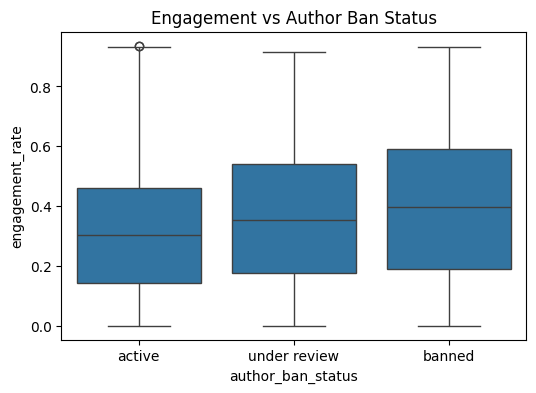

In [30]:
# Check if "under review" videos have higher engagement distribution
plt.figure(figsize=(6,4))
sns.boxplot(x="author_ban_status", y="engagement_rate", data=df,
            order=["active","under review","banned"])
plt.title("Engagement vs Author Ban Status")
plt.show()

In [33]:
"""
Visually confirms the summary stats. High-engagement videos cluster more in “under review” and “banned,” 
suggesting a link between virality and moderation risk.
"""

'\nVisually confirms the summary stats. High-engagement videos cluster more in “under review” and “banned,” \nsuggesting a link between virality and moderation risk.\n'

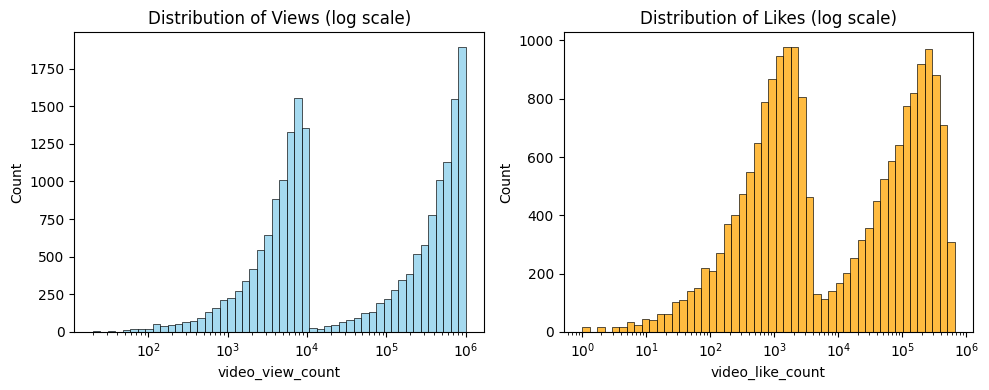

In [34]:
# Distribution of views & likes (log scale)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(df["video_view_count"], bins=50, log_scale=True, color="skyblue")
plt.title("Distribution of Views (log scale)")

plt.subplot(1,2,2)
sns.histplot(df["video_like_count"], bins=50, log_scale=True, color="orange")
plt.title("Distribution of Likes (log scale)")

plt.tight_layout()
plt.show()

In [35]:
#Top N most engaging videos

top_videos = (df.sort_values("engagement_rate", ascending=False)
      [["video_id","claim_status","author_ban_status","engagement_rate","video_view_count"]]
      .head(10))

print("Top 10 most engaging videos:")
display(top_videos)

Top 10 most engaging videos:


,video_id,claim_status,author_ban_status,engagement_rate,video_view_count
736,3218561174,claim,active,0.935961,702492.0
5711,7572100502,claim,active,0.935472,882170.0
1685,6717162038,claim,active,0.932428,242674.0
5569,4362264829,claim,active,0.930334,97178.0
8892,8261213140,claim,active,0.930122,306060.0
7063,2320027652,claim,banned,0.929924,623950.0
7385,4320338657,claim,active,0.929563,274685.0
1322,8405710607,claim,banned,0.928940,993156.0
8458,9521485000,claim,banned,0.928389,534971.0
6375,4875941763,claim,active,0.925579,184342.0


In [36]:
# Crosstab of claim_status vs author_ban_status

ct = pd.crosstab(df["claim_status"], df["author_ban_status"], normalize="index").round(3)

print("Proportion of ban statuses within each claim_status group:")
display(ct)

Proportion of ban statuses within each claim_status group:


author_ban_status,active,banned,under review
claim_status,,,
claim,0.683,0.150,0.167
opinion,0.930,0.021,0.049
unknown,0.940,0.013,0.047


In [38]:
pip install wordcloud


     -------------------------------------- 300.4/300.4 KB 9.4 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\veera\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


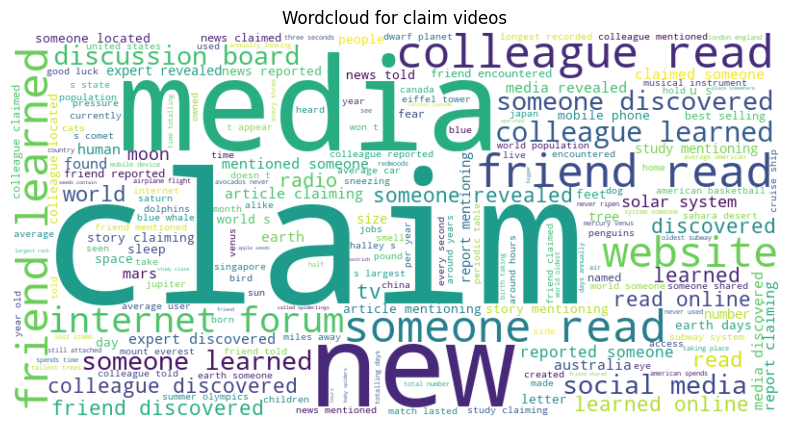

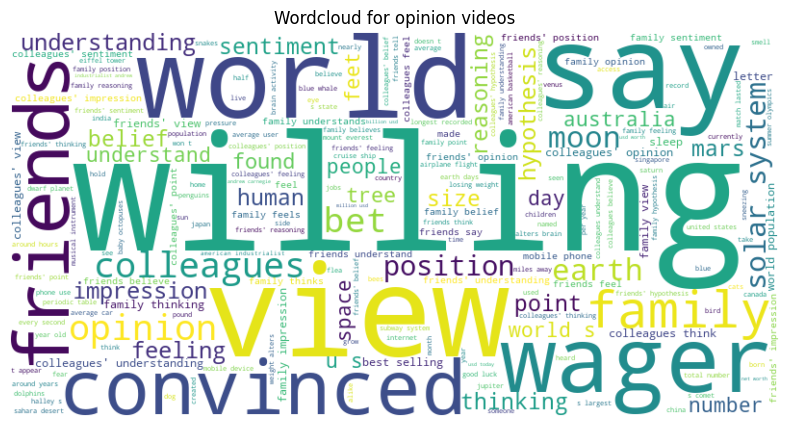

In [39]:
# Wordcloud for claim vs opinion videos
from wordcloud import WordCloud

for label in ["claim","opinion"]:
    text = " ".join(df.loc[df["claim_status"]==label, "video_transcription_text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud for {label} videos")
    plt.show()

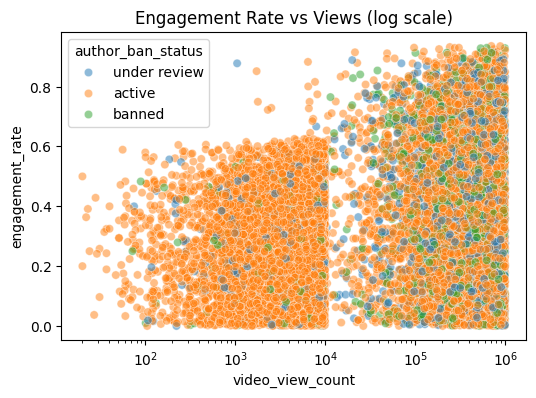

High-engagement outliers (>0.9):


,video_id,claim_status,author_ban_status,engagement_rate,video_view_count
6,4958886992,claim,active,0.925128,750345.0
647,1497295906,claim,under review,0.915277,738552.0
736,3218561174,claim,active,0.935961,702492.0
1199,1613860309,claim,active,0.916779,813173.0
1322,8405710607,claim,banned,0.928940,993156.0
1685,6717162038,claim,active,0.932428,242674.0
1899,9661806287,claim,active,0.902088,119311.0
2141,7893577997,claim,active,0.911740,336357.0
2159,5621844846,claim,banned,0.911070,619501.0
2313,4292060939,claim,banned,0.903044,916347.0


In [40]:
# Outlier detection (views vs engagement_rate)

plt.figure(figsize=(6,4))
sns.scatterplot(x="video_view_count", y="engagement_rate", hue="author_ban_status", 
                data=df, alpha=0.5)
plt.xscale("log")
plt.title("Engagement Rate vs Views (log scale)")
plt.show()

# Check outliers
outliers = df[df["engagement_rate"] > 0.9][["video_id","claim_status","author_ban_status","engagement_rate","video_view_count"]]
print("High-engagement outliers (>0.9):")
display(outliers.head(10))